# Transfer Learning Example (Cats and Dogs)

* 출처  
[TensorFlow 2.x 강의 26] 전이 학습 예제 (Cats and Dogs) (https://www.youtube.com/watch?v=fAgTGrcKE2E)  \
\- 박성호 (neowizard2018@gmail.com)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import sys
print('Python Ver. : ', sys.version)
print('Tensorflow Ver. : ', tf.__version__)

Python Ver. :  3.7.8 (tags/v3.7.8:4b47a5b6ba, Jun 28 2020, 08:53:46) [MSC v.1916 64 bit (AMD64)]
Tensorflow Ver. :  2.7.0


## Cats and Dogs 데이터 가져오기

In [6]:
!pip install wget

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9679 sha256=f12a8c00223d800d05ab02995d9cb03cf8719066761fcd9abe70979c13070849
  Stored in directory: c:\users\mrels_0u60qxz\appdata\local\pip\cache\wheels\a1\b6\7c\0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [7]:
import wget
url= 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
wget.download(url)

  6% [....                                                                    ]  4194304 / 68606236

 19% [..............                                                          ] 13639680 / 68606236

 33% [........................                                                ] 23289856 / 68606236

 49% [...................................                                     ] 33947648 / 68606236

 66% [...............................................                         ] 45522944 / 68606236

 82% [...........................................................             ] 56860672 / 68606236

 99% [....................................................................... ] 68452352 / 68606236

100% [........................................................................] 68606236 / 68606236

'cats_and_dogs_filtered.zip'

In [16]:
import os
import shutil

if os.path.exists('./content/cats_and_dogs.filtered/'):
    shutil.rmtree('./content/cats_and_dogs.filtered/')
    print('./content/cats_and_dogs.filtered/ is removed !!!')

./content/cats_and_dogs.filtered/ is removed !!!


In [17]:
# 압축 파일 풀기
import zipfile
with zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r') as target_file:
    target_file.extractall('./content/')

## Pre-trained model로 Xception 사용

In [4]:
# include=False이므로 Xception 모델은 feature extractor로만 사용됨
IMG_WIDTH = 224
IMG_HEIGHT = 224
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

## base model에 user-defined classifier를 추가

In [5]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax')) # 정담(label)은 'cat', 'dog' 2개이므로 출력층 노드는 2게
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
Non-trainable params: 54,528
_______________________________________

## Image Data Generator 설정

In [6]:
train_dir = './content/cats_and_dogs_filtered/train'
test_dir = './content/cats_and_dogs_filtered/validation'
train_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(train_dir, batch_size=32, color_mode='rgb', shuffle=True, class_mode='categorical', target_size=(IMG_WIDTH,IMG_HEIGHT))
test_data = test_data_gen.flow_from_directory(test_dir, batch_size=32, color_mode='rgb', shuffle=True, class_mode='categorical', target_size=(IMG_WIDTH,IMG_HEIGHT))

# 정답 확인
print(train_data.class_indices.items())
print(test_data.class_indices.items())

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])


In [7]:
type(train_data)

keras.preprocessing.image.DirectoryIterator

## Compile Model (모델 컴파일)

In [8]:
# Fine-Tuning은 학습율을 낮게(2e-5) 설정해서 pre-trained weights를 조금씩 업데이트 해주는 것이 핵심임
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

## Fit Model (모델 학습)

In [9]:
# Callback 함수로, checkpoint와 earlystopping 설정
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
save_file_name = './cats_and_dogs_filtered_Xception.h5'
checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
earlystopping = EarlyStopping(monitor='val_loss', patience=5)

In [10]:
# Fit (학습)
hist = model.fit(train_data, epochs=30, validation_data=test_data) #, callbacks=[checkpoint, earlystopping])

Epoch 1/30
63/63 [==============================] - 308s 5s/step - loss: 0.4821 - accuracy: 0.7995 - val_loss: 0.1357 - val_accuracy: 0.9650
Epoch 2/30
63/63 [==============================] - 303s 5s/step - loss: 0.1949 - accuracy: 0.9530 - val_loss: 0.0517 - val_accuracy: 0.9820
Epoch 3/30
63/63 [==============================] - 302s 5s/step - loss: 0.1006 - accuracy: 0.9785 - val_loss: 0.0376 - val_accuracy: 0.9850
Epoch 4/30
63/63 [==============================] - 303s 5s/step - loss: 0.0640 - accuracy: 0.9830 - val_loss: 0.0335 - val_accuracy: 0.9840
Epoch 5/30
63/63 [==============================] - 301s 5s/step - loss: 0.0471 - accuracy: 0.9885 - val_loss: 0.0326 - val_accuracy: 0.9850
Epoch 6/30
63/63 [==============================] - 304s 5s/step - loss: 0.0306 - accuracy: 0.9935 - val_loss: 0.0348 - val_accuracy: 0.9830
Epoch 7/30
63/63 [==============================] - 305s 5s/step - loss: 0.0367 - accuracy: 0.9890 - val_loss: 0.0305 - val_accuracy: 0.9860
Epoch 8/30
63

## 손실 및 정확도 그려 보기

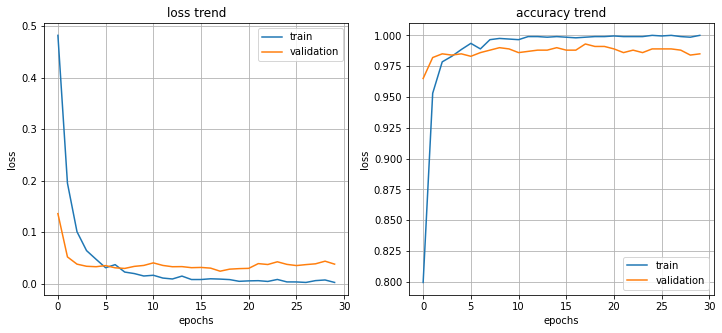

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# 손실 그리기
plt.subplot(1,2,1)
plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')

# 정확도 그리기
plt.subplot(1,2,2)
plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

## 테스트 데이터 로드 및 예측

In [12]:
import os
import shutil

if os.path.exists('./content/test_img_dir/'):
    shutil.rmtree('./content/test_img_dir/')
    print('./content/test_img_dir/ is removed !!!')

In [13]:
# 압축 파일 풀기
import zipfile
with zipfile.ZipFile('test_cats_and_dogs.zip', 'r') as target_file:
    target_file.extractall('./content/test_img_dir/')

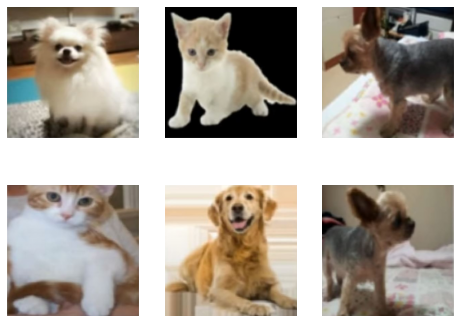

In [33]:
import cv2
import glob

test_img_list = []
test_img_name_list = glob.glob('./content/test_img_dir/*')
for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH,IMG_HEIGHT))
    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img = dst_img / 255.0
    test_img_list.append(dst_img)

plt.figure(figsize=(8,6))
for i in range(len(test_img_list)):
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])
plt.show()

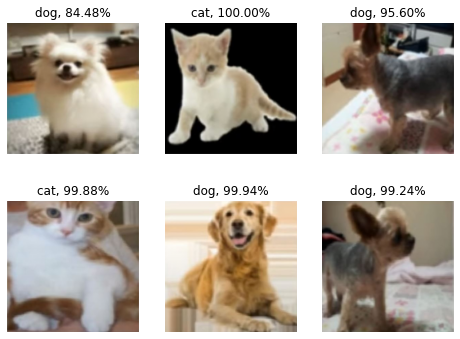

In [42]:
import numpy as np

# batch 차원을 추가하여 predict 실행 (batch_size, width, height, channel)
pred = model.predict(np.array(test_img_list))

class_name = ['cat', 'dog']

plt.figure(figsize=(8,6))
for i in range(len(pred)):
    plt.subplot(2,3,i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probability = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ', ' + probability + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])
plt.show()

## 모델 저장하기

In [41]:
model.save('cats_and_dogs_xfer.h5')

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
